# Analysis for Feature Engineering

In [267]:
import pandas as pd
import os
import glob

csv_files = [f for f in os.listdir() if f.startswith("train") and f.endswith(".csv")]
df_list = [pd.read_csv(file) for file in csv_files]

train_df = pd.concat(df_list, ignore_index=True)
print("Loaded files:", list(dataframes.keys()))
dataframes[csv_files[0]].head()

if 'Unnamed: 0' in train_df.columns:
    train_df = train_df.drop(columns=['Unnamed: 0'])

#json
directing_df = pd.read_json("directing.json")
writing_df = pd.read_json("writing.json")

train_df.head() 

#combine (its not needed I was just trying if it works)
combined_train_df = pd.concat(dataframes.values(), ignore_index=True)
print("Combined train dataset shape:", combined_train_df.shape)

if 'Unnamed: 0' in combined_train_df.columns:
    combined_train_df = combined_train_df.drop(columns=['Unnamed: 0'])

train_df.head() 

Loaded files: ['train-6.csv', 'train-7.csv', 'train-5.csv', 'train-4.csv', 'train-1.csv', 'train-3.csv', 'train-2.csv', 'train-8.csv']
Combined train dataset shape: (7959, 9)


,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,tt0013257,Häxan,Häxan,1922,\N,91,13679.0,True
1,tt0013556,Robin Hood,NaN,1922,\N,143,2178.0,True
2,tt0014341,Our Hospitality,Our Hospitality,1923,\N,65,10911.0,True
3,tt0014538,Three Ages,NaN,1923,\N,63,4312.0,True
4,tt0017925,The General,NaN,1926,\N,67,87784.0,True


In [231]:
####analysis of merged train df

import duckdb
#duck tables
con = duckdb.connect(database=":memory:")
con.register("train_table", train_df)
con.register("directing_table", directing_df)
con.register("writing_table", writing_df)

con.sql("SELECT * FROM train_table LIMIT 5").df()

### originaltitle and num Votes missing, unnamed column
train_df.isnull().sum()

#but primary titles not missing so we can replace the original titile with primary as it is always there (?)
train_df["primaryTitle"].isnull().sum()

#duplicates (no duplicates)
duplicate_count = train_df.duplicated(subset=["primaryTitle", "startYear"]).sum()
print(f"No of duplicates: {duplicate_count}")

#some cols are objects, label = boolean, floats are ok 
print(train_df.dtypes)

#minutes(outlier= too long movies approx 500 min-not outlier)
train_df["runtimeMinutes"].describe()


#right skewed data= mean lower than median (some movies have not many votes whereas others a lot)
train_df["numVotes"].describe()

### convert objects to num for numerical measures
numeric_cols = ["startYear", "endYear", "runtimeMinutes"]
for col in numeric_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors="coerce")
print(train_df.dtypes)

No of duplicates: 0
tconst             object
primaryTitle       object
originalTitle      object
startYear         float64
endYear           float64
runtimeMinutes    float64
numVotes          float64
label                bool
dtype: object
tconst             object
primaryTitle       object
originalTitle      object
startYear         float64
endYear           float64
runtimeMinutes    float64
numVotes          float64
label                bool
dtype: object


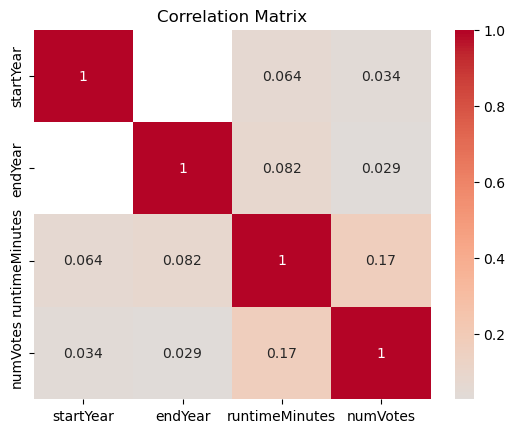

In [233]:
#correlations for all (idk why i need this)
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = train_df.select_dtypes(include=['number']).columns
corr_matrix = train_df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()




In [241]:
#lengths of move titles??
train_df['primaryTitleLength'] = train_df['primaryTitle'].str.len()
train_df['originalTitleLength'] = train_df['originalTitle'].str.len()

print(train_df[['primaryTitleLength', 'originalTitleLength']].describe())

#length of titles
train_df['primaryTitleLength'] = train_df['primaryTitle'].str.len()
train_df['originalTitleLength'] = train_df['originalTitle'].str.len()

#distribution of title lengths
print(train_df[['primaryTitleLength', 'originalTitleLength']].describe())

#grouping by titles
title_rating_avg = train_df.groupby('primaryTitle')['label'].mean()


title_diff = train_df[train_df["primaryTitle"] != train_df["originalTitle"]]
print(title_diff[["primaryTitle", "originalTitle"]].head())

       primaryTitleLength  originalTitleLength
count         7959.000000          3971.000000
mean            15.651589            15.699572
std              8.803379             9.263462
min              1.000000             1.000000
25%             10.000000             9.000000
50%             14.000000            14.000000
75%             19.000000            19.000000
max             86.000000           104.000000
       primaryTitleLength  originalTitleLength
count         7959.000000          3971.000000
mean            15.651589            15.699572
std              8.803379             9.263462
min              1.000000             1.000000
25%             10.000000             9.000000
50%             14.000000            14.000000
75%             19.000000            19.000000
max             86.000000           104.000000
  primaryTitle               originalTitle
1   Robin Hood                         NaN
3   Three Ages                         NaN
4  The General           

count    7959.000000
mean        0.009225
std         0.160825
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: primaryTitleSentiment, dtype: float64


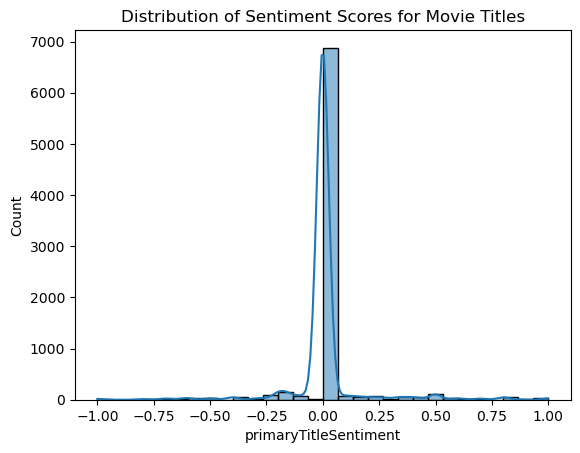

In [237]:
#sentiment analysis for movie titles (basically neutral)
from textblob import TextBlob
train_df['primaryTitleSentiment'] = train_df['primaryTitle'].apply(lambda x: TextBlob(x).sentiment.polarity)
print(train_df['primaryTitleSentiment'].describe())

sns.histplot(train_df['primaryTitleSentiment'], kde=True, bins=30)
plt.title('Distribution of Sentiment Scores for Movie Titles')
plt.show()

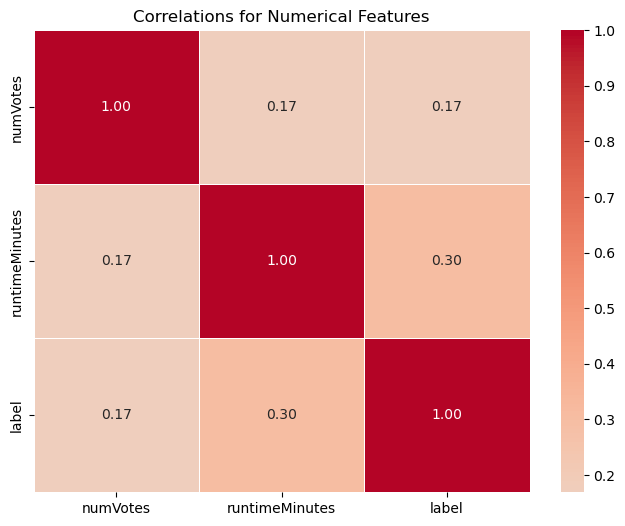

In [243]:
#any correl with label??
numeric_cols = ['numVotes', 'runtimeMinutes', 'label'] 
corr_matrix = train_df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt='.2f', linewidths=0.5)
plt.title("Correlations for Numerical Features")
plt.show()

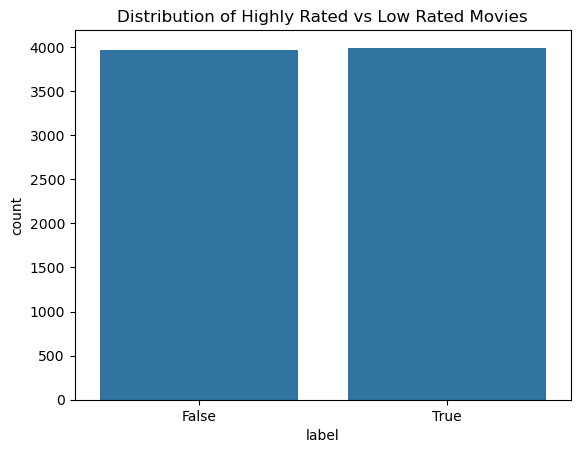

label
True     3990
False    3969
Name: count, dtype: int64


In [245]:
#class balance
sns.countplot(x="label", data=train_df)
plt.title("Distribution of Highly Rated vs Low Rated Movies")
plt.show()

#more less the same no imbalance
print(train_df["label"].value_counts())

In [ ]:
#### the json files: 
print(directing_df.head())
print(writing_df.head())
print(train_df.head())

merged_df = pd.merge(directing_df, writing_df, on='movie', how='left') #movie is the same for both jsons
#print(merged_df.head())


       movie   director
0  tt0003740  nm0665163
1  tt0008663  nm0803705
2  tt0009369  nm0428059
3  tt0009369  nm0949648
4  tt0010307  nm0304098
       movie     writer
0  tt0003740  nm0195339
1  tt0003740  nm0515385
2  tt0003740  nm0665163
3  tt0003740  nm0758215
4  tt0008663  nm0406585
      tconst     primaryTitle    originalTitle  startYear  endYear  \
0  tt0013257            Häxan            Häxan     1922.0      NaN   
1  tt0013556       Robin Hood              NaN     1922.0      NaN   
2  tt0014341  Our Hospitality  Our Hospitality     1923.0      NaN   
3  tt0014538       Three Ages              NaN     1923.0      NaN   
4  tt0017925      The General              NaN     1926.0      NaN   

   runtimeMinutes  numVotes  label  primaryTitleLength  originalTitleLength  \
0            91.0   13679.0   True                   5                  5.0   
1           143.0    2178.0   True                  10                  NaN   
2            65.0   10911.0   True                  15

In [167]:
print(merged_df.head()) #merged directors and writers

       movie   director     writer
0  tt0003740  nm0665163  nm0195339
1  tt0003740  nm0665163  nm0515385
2  tt0003740  nm0665163  nm0665163
3  tt0003740  nm0665163  nm0758215
4  tt0008663  nm0803705  nm0406585


In [ ]:
#analysis of merged json files
#counts of each unique movie id
movie_counts = merged_df['movie'].value_counts()
#print(movie_counts.head())

#duplicates: multiple directors, multiple writers for movies->>>>>> aggregate
duplicates = merged_df[merged_df.duplicated(subset='movie', keep=False)]
#print(duplicates)

#missing data (no missing data)
#print(merged_df.isnull().sum())

#no of dir per movie
directors_count = merged_df.groupby('movie')['director'].nunique()
writers_count = merged_df.groupby('movie')['writer'].nunique()

#common dir and writters + top dir and writers
common_directors = merged_df['director'].value_counts().head(10)
common_writers = merged_df['writer'].value_counts().head(10)
print("Top 10 Directors:\n", common_directors)
print("Top 10 Writers:\n", common_writers)


#director writer matches= director and writer are the same person 
director_writer_match = merged_df[merged_df['director'] == merged_df['writer']]
print(director_writer_match[['movie', 'director', 'writer']].head())

Top 10 Directors:
 director
nm0002030    79
nm0000033    71
nm0851537    50
nm0166256    50
nm0615780    50
nm0001054    49
nm0943758    48
nm0001053    47
nm0000406    46
nm0001120    45
Name: count, dtype: int64
Top 10 Writers:
 writer
\N           420
nm0001054     38
nm0001053     38
nm1175724     35
nm0372942     35
nm0670328     31
nm0945369     30
nm1440023     30
nm0000636     30
nm0901286     29
Name: count, dtype: int64
        movie   director     writer
2   tt0003740  nm0665163  nm0665163
6   tt0008663  nm0803705  nm0803705
11  tt0010307  nm0304098  nm0304098
14  tt0010600  nm0523932  nm0523932
19  tt0011607  nm0003433  nm0003433


In [277]:
#top rated
merged_df = train_df.merge(directing_df, left_on='tconst', right_on='movie', how='left')
merged_df = merged_df.merge(writing_df, on='movie', how='left')

high_rated_movies = merged_df[merged_df['label'] == True]
top_directors = high_rated_movies['director'].value_counts().head(10)
top_writers = high_rated_movies['writer'].value_counts().head(10)

print("Top 10 Directors with Most Highly Rated Films:\n", top_directors)
print("\nTop 10 Writers with Most Highly Rated Films:\n", top_writers)




Top 10 Directors with Most Highly Rated Films:
 director
nm0002030    79
nm0000033    49
nm0001054    45
nm0615780    44
nm0166256    44
nm0001053    43
nm0943758    41
nm0851537    40
nm0668247    39
nm0001120    39
Name: count, dtype: int64

Top 10 Writers with Most Highly Rated Films:
 writer
\N           322
nm0001054     32
nm0001053     32
nm0372942     25
nm0668247     24
nm0878756     23
nm0000801     23
nm0170043     23
nm0158984     22
nm0001814     22
Name: count, dtype: int64


In [288]:
#worse rated
low_rated_movies = merged_df[merged_df['label'] == False]
worst_directors = low_rated_movies['director'].value_counts().head(10)
worst_writers = low_rated_movies['writer'].value_counts().head(10)

print("Top 10 Directors with most low-rated films:\n", worst_directors)
print("\nTop 10 Writers with most low-rated films:\n", worst_writers)

Top 10 Directors with most low-rated films:
 director
nm0109359    38
nm0001238    34
nm1175724    26
nm1460159    26
nm0945369    24
nm0268380    23
nm1296554    23
nm0001162    23
nm1883583    22
nm0192090    22
Name: count, dtype: int64

Top 10 Writers with most low-rated films:
 writer
nm1175724    30
nm1440023    30
nm3094978    28
nm1443023    28
nm1883583    28
nm1104993    28
nm0305563    28
nm0945369    28
nm0750121    28
nm6164520    27
Name: count, dtype: int64


In [ ]:
#Unique
num_unique_directors = merged_df['director'].nunique()
num_unique_writers = merged_df['writer'].nunique()

print(f"Unique Directors: {num_unique_directors}")
print(f"Unique Writers: {num_unique_writers}")

Unique Directors: 6082
Unique Writers: 12751
